In [20]:
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

import tensorflow as tf
print('Configurando TF')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Configurando TF


In [2]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1,  scale=True, label=False):
    serie = data['ADJ_CLOSE'].values.reshape(data.shape[0],1)
    X, Y, labels = [],[],[]
    for i in range(0,len(serie) -look_back -forward_days +1, jump):
        d = serie[i:i+look_back+forward_days]
        if scale == True:
            d = MinMaxScaler().fit_transform( d )
        X.append(d[:look_back])
        Y.append(d[look_back:look_back+forward_days])
        labels.append(data.iloc[i+look_back-1])
    return X,Y,labels

In [18]:
# Rutinas

def plot_accuracy(hist):
    pyplot.plot(hist['acc'])
    pyplot.plot(hist['val_acc'])
    pyplot.legend(['train', 'validation'], loc='upper left')
    
def plot_error(hist):
    pyplot.plot(hist['loss'])
    pyplot.plot(hist['val_loss'])
    pyplot.legend(['train', 'validation'], loc='upper left')
    
def plot_confusion_matrix(y_pred, y_test):
    con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #con_mat_norm = np.around(con_mat / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_norm = np.around(100 * con_mat / len(y_test), decimals=3)
    con_mat_df = pd.DataFrame(con_mat_norm, index = [i for i in range(0,len(con_mat))], columns = [i for i in range(0,len(con_mat))])
    figure = pyplot.figure(figsize=(4, 4))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, square=True, cbar=False, fmt='f')
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

def output(y_pred, threshold=0.5):
    if len(y_pred.shape) > 1:
        if y_pred.shape[1] > 1:
            return [np.argmax(x) for x in y_pred]
        else:
            return [ 1 if x >= threshold else 0 for x in y_pred ]
    else:
        return [ 1 if x >= threshold else 0 for x in y_pred ]

def accuracy(y_pred, y_test):
    acc = np.array([ y_pred[i] == y_test[i] for i in range(0,len(y_test))])
    return acc.sum()/len(acc)

def labels_up(actuals, y_pred):
    assert len(actuals) == len(y_pred)
    labels = []
    for i in range(len(actuals)):
        if y_pred[i] >= actuals[i]['UPPER_LIMIT']:
            labels.append(1)
        else:
            labels.append(0)
    return labels

def extract_label(y):
    labels = []
    for x in y:
        labels.append(x['LABEL'])
    return labels

# Test

In [4]:
from sklearn.preprocessing import MinMaxScaler
look_back = 100
forward_days = 30
num_periods = 20

In [5]:
model = load_model("/home/benayas/results/best_lstm_test_all.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
df_test = pd.read_feather("/home/benayas/datasets/lstm/test/test.feather")
X = []
y = []
actual_labels = []
for s, group in df_test.groupby('SYMBOL'):
    X_t, y_t, labels = processData( group, look_back, forward_days, jump=num_periods, scale=False, label=True)
    X = X + X_t
    y = y + y_t
    actual_labels = actual_labels + labels

X_test = np.array(X)
y_test = np.array(y)

In [189]:
df_test = pd.read_feather("/home/benayas/datasets/lstm/test/test.feather")
appl_test = df_test[df_test['SYMBOL']=='AAPL']
#array_test = appl_test['ADJ_CLOSE'].values.reshape(appl_test.shape[0],1)

X_test, y_test, actual_labels = processData( appl_test, look_back, forward_days, jump=num_periods, scale=False, label=True)

In [7]:
print('X shape {0}'.format(X_test.shape))
print('Y shape {0}'.format(y_test.shape))
print('Labels shape {0}'.format(len(actual_labels)))

X shape (47088, 100, 1)
Y shape (47088, 30, 1)
Labels shape 47088


In [11]:
pred_values = []
for i in tqdm(range(0,len(X_test))):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    y_pred = scl.inverse_transform(y_pred.reshape(-1,1))
    pred_values.append(y_pred[-1:][0])

pred_values = np.array(pred_values)

100%|██████████| 47088/47088 [47:41<00:00, 16.46it/s]


In [192]:
pred_values.shape

(22, 1)

In [12]:
y_pred = labels_up(actual_labels, pred_values)
y_test = extract_label(actual_labels)

In [13]:
accuracy(y_pred, y_test)

0.8716233435270132

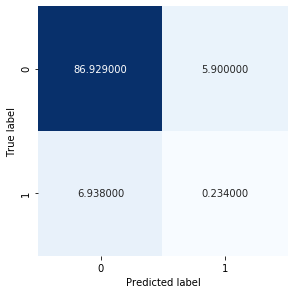

In [21]:
plot_confusion_matrix(y_pred, y_test)